# instalacion Spark

In [ ]:
from bs4 import BeautifulSoup
import requests
url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
print(spark_link)


['spark-2.4.8/', 'spark-3.0.3/', 'spark-3.1.2/', 'spark-3.1.3/', 'spark-3.2.1/']


In [ ]:
ver_spark = spark_link[1][:-1] 
print(ver_spark)

spark-3.0.3


In [ ]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.system(f"wget -q {url+ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")
!ls

sample_data  spark-3.0.3-bin-hadoop2.7	spark-3.0.3-bin-hadoop2.7.tgz


In [ ]:
!pip install -q pyspark
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop2.7"

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 40.2 MB/s 


In [ ]:
!ls

sample_data  spark-3.0.3-bin-hadoop2.7	spark-3.0.3-bin-hadoop2.7.tgz


In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config("spark.driver.memory","12g") \
        .config("spark.sql.execution.arrow.enabled","true") \
        .getOrCreate()

In [ ]:
spark

## Code

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('default')
%matplotlib inline

## Cargar data

In [ ]:

DATASET_NAME="testUndersampled_HLF_features.parquet"
!wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME

DATASET_NAME="trainUndersampled_HLF_features.parquet"
!wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME

--2022-06-13 02:37:04--  http://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 188.185.87.216, 137.138.31.235, 188.185.90.87
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|188.185.87.216|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet [following]
--2022-06-13 02:37:05--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|188.185.87.216|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet/ [following]
--2022-06-13 02:37:05--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet/
Reusin

In [ ]:
PATH = "/content/sparkdltrigger.web.cern.ch/sparkdltrigger/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [ ]:
num_test = testDF.count()
num_train = trainDF.count()

print(f"There are {num_test} events in the test dataset")
print(f"There are {num_train} events in the train dataset")

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


In [ ]:
testDF.printSchema()
testDF.limit(5).toPandas()

root
 |-- HLF_input: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- encoded_label: array (nullable = true)
 |    |-- element: double (containsNull = true)



,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"


## Convert training and test datasets from Spark DataFrames to Numpy arrays

In [ ]:
import numpy as np

X = np.array(trainDF.select("HLF_input").collect()).reshape(num_train,14)
y = np.array(trainDF.select("encoded_label").collect()).reshape(num_train,3)

X_test = np.array(testDF.select("HLF_input").collect()).reshape(num_test,14)
y_test = np.array(testDF.select("encoded_label").collect()).reshape(num_test,3)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [ ]:
keras_model = create_model(150,20,50)
history = keras_model.fit(X, y, batch_size=64, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
53533/53533 [==============================] - 139s 3ms/step - loss: 0.2576 - accuracy: 0.9050 - val_loss: 0.2340 - val_accuracy: 0.9137
Epoch 2/50
53533/53533 [==============================] - 138s 3ms/step - loss: 0.2329 - accuracy: 0.9138 - val_loss: 0.2294 - val_accuracy: 0.9154
Epoch 3/50
53533/53533 [==============================] - 139s 3ms/step - loss: 0.2281 - accuracy: 0.9156 - val_loss: 0.2285 - val_accuracy: 0.9156
Epoch 4/50
53533/53533 [==============================] - 140s 3ms/step - loss: 0.2258 - accuracy: 0.9165 - val_loss: 0.2225 - val_accuracy: 0.9181
Epoch 5/50
53533/53533 [==============================] - 136s 3ms/step - loss: 0.2239 - accuracy: 0.9172 - val_loss: 0.2237 - val_accuracy: 0.9177
Epoch 6/50
53533/53533 [==============================] - 140s 3ms/step - loss: 0.2225 - accuracy: 0.9177 - val_loss: 0.2216 - val_accuracy: 0.9183
Epoch 7/50
53533/53533 [==============================] - 139s 3ms/step - loss: 0.2214 - accuracy: 0.9182 - val_

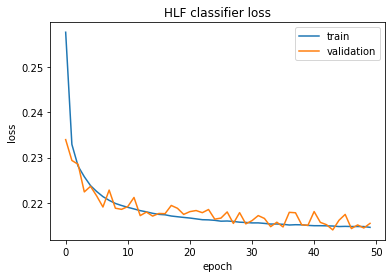

In [ ]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.rcParams["figure.figsize"] = (10,7)

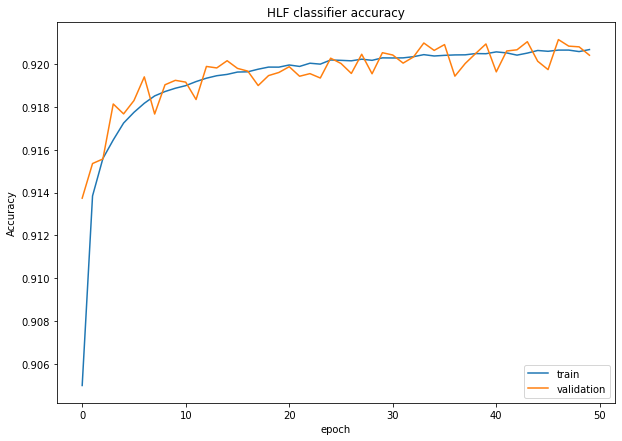

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.rcParams["figure.figsize"] = (10,7)

# Confusion Matrix

In [ ]:
y_pred=history.model.predict(X_test)
y_true=y_test

In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


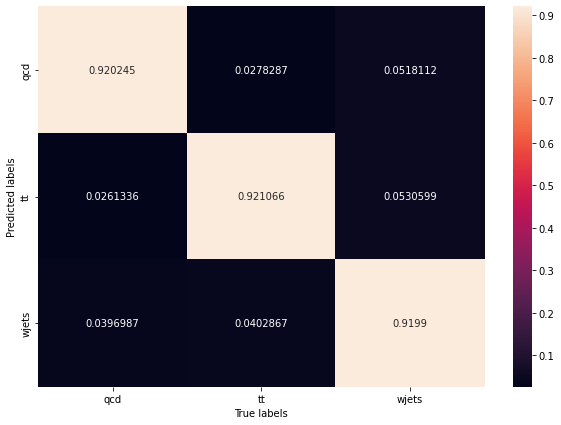

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# ROC y AUC

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9891137424712532, 1: 0.9865896390362606, 2: 0.9831638162517662}

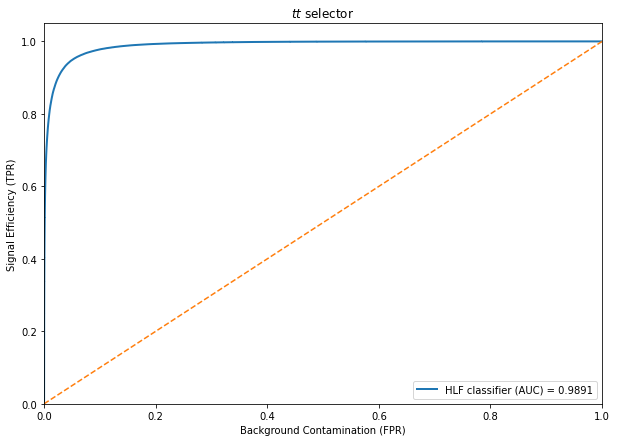

In [ ]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,7)
plt.show()